In [ ]:
from joblib import dump, load
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# For handling grid search parallelization
import os
os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp'

## Load data

In [ ]:
path = Path('.')
data_path = path / 'data'
searches_path = path / 'searches'
models_path = path / 'models'

In [ ]:

train_xs = pd.read_pickle(data_path/'train_xs.pkl')
valid_xs = pd.read_pickle(data_path/'valid_xs.pkl')
train_y = pd.read_pickle(data_path/'train_y.pkl')
valid_y = pd.read_pickle(data_path/'valid_y.pkl')
weights = pd.read_pickle(data_path/'weights.pkl')

In [ ]:
train_indices = train_xs.index
valid_indices = valid_xs.index

In [ ]:
valid_frac = 0.05

## Train models

In [ ]:
import sklearn.metrics as metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

### Random Forest

In [ ]:
m1 = RandomForestClassifier(max_leaf_nodes=16, n_jobs=-2)
m1.fit(train_xs, train_y, sample_weight=weights[train_indices])

RandomForestClassifier(max_leaf_nodes=16, n_jobs=-2)

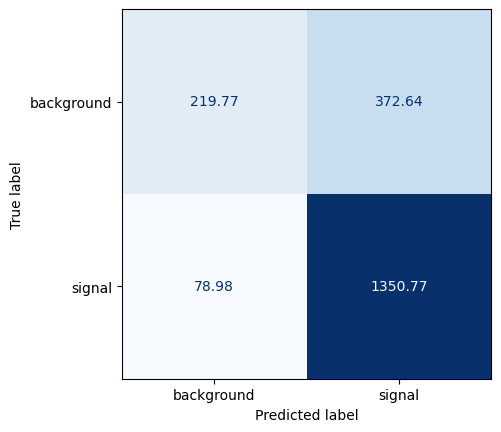

In [ ]:
cm = metrics.ConfusionMatrixDisplay.from_estimator(m1, valid_xs, valid_y, 
                                           sample_weight=weights[valid_indices]/valid_frac,
                                           cmap='Blues', display_labels=['background', 'signal'], 
                                           colorbar=False, values_format='.2f')

In [ ]:
print(f'#signals / #backgrounds: {cm.confusion_matrix[1, 1] / cm.confusion_matrix[0, 1]:.2f}')

#signals / #backgrounds: 3.62


In [ ]:
probs = m1.predict_proba(valid_xs)
probs.max()

149.10897969115254

In [ ]:
m1.feature_importances_

array([9.06124627e-05, 0.00000000e+00, 2.43876291e-04, 3.11726513e-05,
       1.21443783e-04, 9.94386643e-05, 8.60676572e-02, 5.62523099e-02,
       7.49938868e-02, 1.10457841e-01, 1.53973515e-01, 2.67462261e-02,
       2.01728470e-02, 4.14767486e-02, 6.85866495e-02, 1.10024828e-01,
       1.77222762e-02, 4.66420810e-02, 2.33008843e-02, 9.61107592e-02,
       2.89570435e-02, 2.27436499e-02, 1.51842532e-02])

In [ ]:
m2 = RandomForestClassifier(max_leaf_nodes=16, n_jobs=-2)
m2.fit(train_xs, train_y)

RandomForestClassifier(max_leaf_nodes=16, n_jobs=-2)

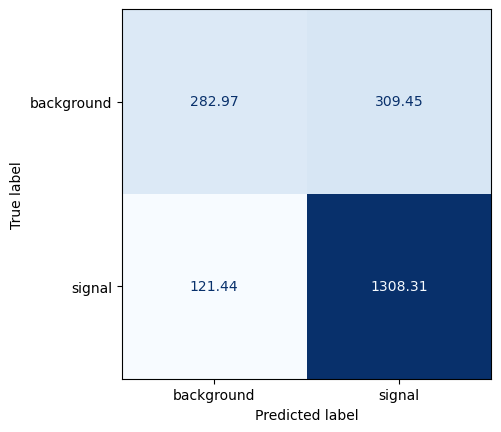

In [ ]:
cm = metrics.ConfusionMatrixDisplay.from_estimator(m2, valid_xs, valid_y, 
                                           sample_weight=weights[valid_indices]/valid_frac,
                                           cmap='Blues', display_labels=['background', 'signal'], 
                                           colorbar=False, values_format='.2f')

In [ ]:
print(f'#signals / #backgrounds: {cm.confusion_matrix[1, 1] / cm.confusion_matrix[0, 1]:.2f}')

#signals / #backgrounds: 4.23


In [ ]:
probs = m2.predict_proba(valid_xs)
probs.max()

0.858564560951517

#### RF Hyperparameter tuning

In [ ]:
# Create a weighted metric decorator
def weighted_metric(metric):
    def weighted_metric_impl(y_true, y_pred, sample_weight):
        return metric(y_true, y_pred, sample_weight=sample_weight.loc[y_true.index.values].values.flatten())
    return weighted_metric_impl

# Create a weighted precision metric
weighted_precision_score = weighted_metric(metrics.precision_score)

In [ ]:
def weighted_true_positives(y_true, y_pred, sample_weight):
    cm = metrics.confusion_matrix(y_true, y_pred, sample_weight=sample_weight.loc[y_true.index.values].values.flatten())
    return cm[1, 1]/cm.sum().sum()

In [ ]:
#merge train xs and valid xs
xs = pd.concat([train_xs, valid_xs])
y = pd.concat([train_y, valid_y])
sample_weights = pd.concat([weights[train_indices], weights[valid_indices]])

In [ ]:
score_params = {'sample_weight': sample_weights}
scoring = {'precision': metrics.make_scorer(weighted_precision_score, **score_params),
           'true_positives': metrics.make_scorer(weighted_true_positives, **score_params)}

In [ ]:
rf = RandomForestClassifier(n_jobs=-3)

param_dist = {'n_estimators': np.linspace(10, 100, 10, dtype=int), 
              'max_leaf_nodes': [2**i for i in range(1, 9)],
              'bootstrap': [True, False],
              'class_weight': [None, 'balanced'] + [{0: x, 1:1} for x in np.linspace(1.5, 6, 10)]}

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, cv=5, scoring=scoring,
                                   return_train_score=True, verbose=4, n_iter=25,
                                   refit=False)

In [ ]:
random_search.fit(xs, y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END bootstrap=True, class_weight=None, max_leaf_nodes=128, n_estimators=60; precision: (train=0.822, test=0.818) true_positives: (train=0.624, test=0.608) total time= 1.1min
[CV 2/5] END bootstrap=True, class_weight=None, max_leaf_nodes=128, n_estimators=60; precision: (train=0.821, test=0.821) true_positives: (train=0.623, test=0.632) total time= 1.1min
[CV 3/5] END bootstrap=True, class_weight=None, max_leaf_nodes=128, n_estimators=60; precision: (train=0.821, test=0.817) true_positives: (train=0.622, test=0.621) total time= 1.1min
[CV 4/5] END bootstrap=True, class_weight=None, max_leaf_nodes=128, n_estimators=60; precision: (train=0.820, test=0.823) true_positives: (train=0.623, test=0.620) total time= 1.0min
[CV 5/5] END bootstrap=True, class_weight=None, max_leaf_nodes=128, n_estimators=60; precision: (train=0.820, test=0.823) true_positives: (train=0.622, test=0.631) total time= 1.1min
[CV 1/5] END bootstrap=

/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END bootstrap=False, class_weight={0: 6.0, 1: 1}, max_leaf_nodes=8, n_estimators=20; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  16.5s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END bootstrap=False, class_weight={0: 6.0, 1: 1}, max_leaf_nodes=8, n_estimators=20; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  19.5s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END bootstrap=False, class_weight={0: 6.0, 1: 1}, max_leaf_nodes=8, n_estimators=20; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  17.9s
[CV 4/5] END bootstrap=False, class_weight={0: 6.0, 1: 1}, max_leaf_nodes=8, n_estimators=20; precision: (train=0.889, test=0.850) true_positives: (train=0.003, test=0.003) total time=  15.9s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END bootstrap=False, class_weight={0: 6.0, 1: 1}, max_leaf_nodes=8, n_estimators=20; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  15.5s
[CV 1/5] END bootstrap=False, class_weight=None, max_leaf_nodes=16, n_estimators=30; precision: (train=0.807, test=0.800) true_positives: (train=0.646, test=0.629) total time=  25.5s
[CV 2/5] END bootstrap=False, class_weight=None, max_leaf_nodes=16, n_estimators=30; precision: (train=0.808, test=0.814) true_positives: (train=0.629, test=0.639) total time=  27.1s
[CV 3/5] END bootstrap=False, class_weight=None, max_leaf_nodes=16, n_estimators=30; precision: (train=0.813, test=0.806) true_positives: (train=0.627, test=0.626) total time=  30.4s
[CV 4/5] END bootstrap=False, class_weight=None, max_leaf_nodes=16, n_estimators=30; precision: (train=0.801, test=0.812) true_positives: (train=0.640, test=0.636) total time=  28.5s
[CV 5/5] END bootstrap=False, class_weight=None, max_leaf_nodes=16, n_estima

/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END bootstrap=True, class_weight={0: 6.0, 1: 1}, max_leaf_nodes=4, n_estimators=40; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  16.2s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END bootstrap=True, class_weight={0: 6.0, 1: 1}, max_leaf_nodes=4, n_estimators=40; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  17.2s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END bootstrap=True, class_weight={0: 6.0, 1: 1}, max_leaf_nodes=4, n_estimators=40; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  17.3s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END bootstrap=True, class_weight={0: 6.0, 1: 1}, max_leaf_nodes=4, n_estimators=40; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  16.4s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END bootstrap=True, class_weight={0: 6.0, 1: 1}, max_leaf_nodes=4, n_estimators=40; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  16.5s
[CV 1/5] END bootstrap=False, class_weight=None, max_leaf_nodes=64, n_estimators=80; precision: (train=0.819, test=0.813) true_positives: (train=0.628, test=0.611) total time= 1.6min
[CV 2/5] END bootstrap=False, class_weight=None, max_leaf_nodes=64, n_estimators=80; precision: (train=0.817, test=0.818) true_positives: (train=0.622, test=0.631) total time= 1.6min
[CV 3/5] END bootstrap=False, class_weight=None, max_leaf_nodes=64, n_estimators=80; precision: (train=0.819, test=0.813) true_positives: (train=0.624, test=0.622) total time= 1.6min
[CV 4/5] END bootstrap=False, class_weight=None, max_leaf_nodes=64, n_estimators=80; precision: (train=0.817, test=0.822) true_positives: (train=0.624, test=0.620) total time= 1.6min
[CV 5/5] END bootstrap=False, class_weight=None, max_leaf_nodes=64, n_estimat

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-3), n_iter=25,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [None, 'balanced',
                                                         {0: 1.5, 1: 1},
                                                         {0: 2.0, 1: 1},
                                                         {0: 2.5, 1: 1},
                                                         {0: 3.0, 1: 1},
                                                         {0: 3.5, 1: 1},
                                                         {0: 4.0, 1: 1},
                                                         {0: 4.5, 1: 1},
                                                         {0: 5.0, 1: 1},
                                                         {0: 5.5, 1: 1},
                                                         {0: 6.0, 1: 1}],
                                        'max_leaf_nodes': [2, 4, 8, 16, 32, 64,
                                                           128, 256],
                                        'n_estimators': array([ 10,  20,  30,...
380343     0.001118
948045     0.000141
Name: rescaled_weight, Length: 958093, dtype: float64),
                            'true_positives': make_scorer(weighted_true_positives, sample_weight=336596     0.000622
1046443    0.000402
994441     0.000627
131389     0.000868
45434      0.000367
             ...   
957916    -0.001084
557435     0.009622
834372     0.000635
380343     0.001118
948045     0.000141
Name: rescaled_weight, Length: 958093, dtype: float64)},
                   verbose=4)

In [ ]:
fname = 'rf_random_search.pkl'
if not (searches_path/fname).exists():
    random_search_results = pd.DataFrame(random_search.cv_results_)
    # Split params into separate columns, class_weights and max_leaf_nodes
    params = random_search_results.params.apply(pd.Series)
    random_search_results = pd.concat([random_search_results, params], axis=1).drop('params', axis=1)
    # Drop split0, split1, ... columns
    random_search_results = random_search_results.loc[:, ~random_search_results.columns.str.startswith('split')]
    random_search_results = random_search_results.loc[:, ~random_search_results.columns.str.startswith('std')]
    random_search_results.to_pickle(searches_path/fname)
else:
    print('loaded file')
    random_search_results = pd.read_pickle(searches_path/fname)    

loaded file


In [ ]:
random_search_results

,mean_fit_time,mean_score_time,mean_test_precision,rank_test_precision,mean_train_precision,mean_test_true_positives,rank_test_true_positives,mean_train_true_positives,n_estimators,max_leaf_nodes,class_weight,bootstrap
0,65.310528,0.496248,0.820194,19,0.820733,0.622693,5,0.622933,60,128,None,True
1,35.537254,0.314332,0.872204,6,0.873368,0.363648,18,0.363702,50,8,"{0: 2.5, 1: 1}",False
2,13.120171,0.197271,0.851719,12,0.853600,0.482886,13,0.483742,10,32,balanced,False
3,16.855565,0.210204,0.169982,24,0.177807,0.000577,24,0.000590,20,8,"{0: 6.0, 1: 1}",False
4,27.641873,0.305916,0.806077,22,0.805708,0.637065,2,0.637705,30,16,None,False
5,36.482733,0.462178,0.855597,11,0.856071,0.470140,15,0.470453,40,16,"{0: 2.0, 1: 1}",True
6,206.384191,0.865930,0.844067,14,0.845974,0.556500,9,0.557927,100,256,"{0: 1.5, 1: 1}",False
7,17.802113,0.330838,0.891464,4,0.899292,0.138713,21,0.137352,40,4,"{0: 3.0, 1: 1}",True
8,66.440716,0.394479,0.855762,10,0.857181,0.480244,14,0.480349,70,16,"{0: 2.0, 1: 1}",False
9,51.781717,0.411473,0.892986,3,0.891587,0.212937,20,0.214199,70,32,"{0: 4.0, 1: 1}",True


In [ ]:
random_search_results.query('mean_test_precision > 0.8 and mean_test_true_positives > 0.35').sort_values('mean_test_precision', ascending=False).head()

,mean_fit_time,mean_score_time,mean_test_precision,rank_test_precision,mean_train_precision,mean_test_true_positives,rank_test_true_positives,mean_train_true_positives,n_estimators,max_leaf_nodes,class_weight,bootstrap
1,35.537254,0.314332,0.872204,6,0.873368,0.363648,18,0.363702,50,8,"{0: 2.5, 1: 1}",False
23,185.319376,0.844174,0.870297,7,0.874118,0.407587,16,0.409128,100,256,"{0: 2.5, 1: 1}",False
10,10.390407,0.217654,0.865719,8,0.869822,0.395634,17,0.397155,10,64,"{0: 2.5, 1: 1}",True
22,43.191130,0.326851,0.858085,9,0.861479,0.494272,11,0.496615,20,256,balanced,False
8,66.440716,0.394479,0.855762,10,0.857181,0.480244,14,0.480349,70,16,"{0: 2.0, 1: 1}",False


#### Best RF

In [ ]:
fname = 'best_rf.joblib'
if not (models_path/fname).exists():
    m1 = RandomForestClassifier(n_estimators=100, max_leaf_nodes=256, class_weight={0: 2.5, 1: 1}, bootstrap=False, n_jobs=-3)
    m1.fit(xs, y)
    dump(m1, models_path/fname)
else:
    print('loaded file')
    m1 = load(models_path/fname)

loaded file


In [ ]:
m1.feature_importances_

array([5.59872537e-04, 1.07236295e-03, 1.38805316e-03, 1.49306238e-03,
       2.04077990e-03, 1.36836855e-03, 5.14914214e-02, 2.43496201e-02,
       2.70394834e-02, 4.53524165e-01, 3.05002777e-01, 4.00438165e-02,
       9.83204069e-03, 1.12757698e-02, 7.43281989e-06, 2.92724213e-02,
       8.41056465e-03, 1.05506763e-02, 3.66315390e-06, 1.25961168e-02,
       4.93174322e-03, 3.74258156e-03, 3.20662001e-06])

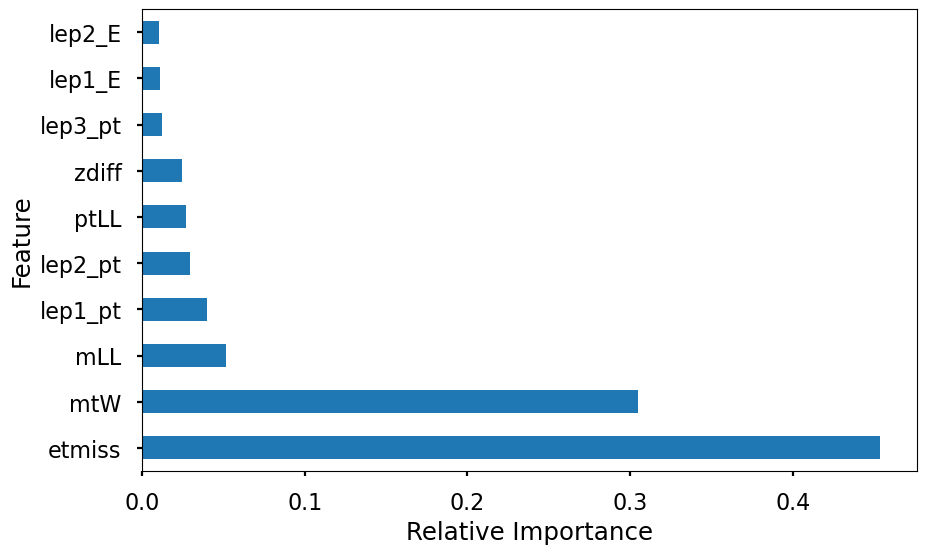

In [ ]:
plt.style.use('seaborn-v0_8-poster')
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(m1.feature_importances_, index=train_xs.columns)
feat_importances = feat_importances.nlargest(10)
feat_importances.plot(kind='barh')
ax = plt.gca()
ax.set_xlabel('Relative Importance')
ax.set_ylabel('Feature');

### BDT

In [ ]:
bdt1 = HistGradientBoostingClassifier()
bdt1.fit(train_xs, train_y)

HistGradientBoostingClassifier()

In [ ]:
cm = metrics.confusion_matrix(valid_y, bdt1.predict(valid_xs), sample_weight=weights[valid_indices]/valid_frac)
print(cm)
print(f'#signals / #backgrounds: {cm[1, 1] / cm[0, 1]:.2f}')

[[ 377.20571191  215.20999243]
 [ 198.05205543 1231.69744004]]
#signals / #backgrounds: 5.72


#### Hyperparameter tuning

In [ ]:
#merge train xs and valid xs
xs = pd.concat([train_xs, valid_xs])
y = pd.concat([train_y, valid_y])
sample_weights = pd.concat([weights[train_indices], weights[valid_indices]])

In [ ]:
score_params = {'sample_weight': sample_weights}
scoring = {'precision': metrics.make_scorer(weighted_precision_score, **score_params),
           'true_positives': metrics.make_scorer(weighted_true_positives, **score_params)}

In [ ]:
bdt = HistGradientBoostingClassifier()

param_dist = {'learning_rate': [0.001, 0.01, 0.1],
              'max_depth': [3, 5, 7, 9],
              'min_samples_leaf': [1, 5, 10, 20],
              'l2_regularization': [0.0, 0.1, 0.01, 0.001],
              'max_bins': [63, 127, 255],
              'max_iter': [50, 100, 200, 500, 1000],
              'class_weight': [None, 'balanced'] + [{0: x, 1:1} for x in np.linspace(1.5, 6, 10)]}

random_search = RandomizedSearchCV(bdt, param_distributions=param_dist, cv=5, scoring=scoring,
                                   return_train_score=True, verbose=4, n_iter=25,
                                   n_jobs=5, refit=False)

In [ ]:
random_search.fit(xs, y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 4/5] END class_weight={0: 4.5, 1: 1}, l2_regularization=0.01, learning_rate=0.1, max_bins=255, max_depth=7, max_iter=200, min_samples_leaf=5; precision: (train=0.904, test=0.892) true_positives: (train=0.285, test=0.279) total time= 1.0min
[CV 3/5] END class_weight={0: 4.5, 1: 1}, l2_regularization=0.01, learning_rate=0.1, max_bins=255, max_depth=7, max_iter=200, min_samples_leaf=5; precision: (train=0.900, test=0.897) true_positives: (train=0.287, test=0.284) total time= 1.0min
[CV 2/5] END class_weight={0: 4.5, 1: 1}, l2_regularization=0.01, learning_rate=0.1, max_bins=255, max_depth=7, max_iter=200, min_samples_leaf=5; precision: (train=0.899, test=0.903) true_positives: (train=0.286, test=0.290) total time= 1.1min
[CV 1/5] END class_weight={0: 4.5, 1: 1}, l2_regularization=0.01, learning_rate=0.1, max_bins=255, max_depth=7, max_iter=200, min_samples_leaf=5; precision: (train=0.903, test=0.885) true_positives: (train=

/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-

[CV 1/5] END class_weight={0: 5.0, 1: 1}, l2_regularization=0.0, learning_rate=0.001, max_bins=127, max_depth=5, max_iter=50, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  27.2s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END class_weight={0: 5.0, 1: 1}, l2_regularization=0.0, learning_rate=0.001, max_bins=127, max_depth=5, max_iter=50, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  27.4s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END class_weight={0: 5.0, 1: 1}, l2_regularization=0.0, learning_rate=0.001, max_bins=127, max_depth=5, max_iter=50, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  27.5s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END class_weight={0: 5.0, 1: 1}, l2_regularization=0.0, learning_rate=0.001, max_bins=127, max_depth=5, max_iter=50, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  27.7s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END class_weight={0: 5.0, 1: 1}, l2_regularization=0.0, learning_rate=0.001, max_bins=127, max_depth=5, max_iter=50, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  27.7s
[CV 1/5] END class_weight={0: 4.5, 1: 1}, l2_regularization=0.0, learning_rate=0.01, max_bins=63, max_depth=9, max_iter=50, min_samples_leaf=5; precision: (train=0.928, test=0.962) true_positives: (train=0.014, test=0.013) total time=  23.5s
[CV 2/5] END class_weight={0: 4.5, 1: 1}, l2_regularization=0.0, learning_rate=0.01, max_bins=63, max_depth=9, max_iter=50, min_samples_leaf=5; precision: (train=0.935, test=0.930) true_positives: (train=0.020, test=0.022) total time=  23.7s
[CV 3/5] END class_weight={0: 4.5, 1: 1}, l2_regularization=0.0, learning_rate=0.01, max_bins=63, max_depth=9, max_iter=50, min_samples_leaf=5; precision: (train=0.935, test=0.941) true_positives: (train=0.015, test=0.015) total time=  23.9s
[CV 4/5] END class_weight={0:

/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-

[CV 1/5] END class_weight={0: 5.0, 1: 1}, l2_regularization=0.0, learning_rate=0.001, max_bins=63, max_depth=7, max_iter=200, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 2.0min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END class_weight={0: 5.0, 1: 1}, l2_regularization=0.0, learning_rate=0.001, max_bins=63, max_depth=7, max_iter=200, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 2.0min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END class_weight={0: 5.0, 1: 1}, l2_regularization=0.0, learning_rate=0.001, max_bins=63, max_depth=7, max_iter=200, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 2.0min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END class_weight={0: 5.0, 1: 1}, l2_regularization=0.0, learning_rate=0.001, max_bins=63, max_depth=7, max_iter=200, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 2.0min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END class_weight={0: 5.0, 1: 1}, l2_regularization=0.0, learning_rate=0.001, max_bins=63, max_depth=7, max_iter=200, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 1.9min
[CV 3/5] END class_weight={0: 3.5, 1: 1}, l2_regularization=0.001, learning_rate=0.001, max_bins=127, max_depth=9, max_iter=500, min_samples_leaf=5; precision: (train=0.881, test=0.894) true_positives: (train=0.066, test=0.067) total time= 3.9min
[CV 4/5] END class_weight={0: 3.5, 1: 1}, l2_regularization=0.001, learning_rate=0.001, max_bins=127, max_depth=9, max_iter=500, min_samples_leaf=5; precision: (train=0.895, test=0.897) true_positives: (train=0.076, test=0.076) total time= 3.8min
[CV 1/5] END class_weight={0: 3.5, 1: 1}, l2_regularization=0.001, learning_rate=0.001, max_bins=127, max_depth=9, max_iter=500, min_samples_leaf=5; precision: (train=0.901, test=0.891) true_positives: (train=0.077, test=0.072) total time= 3.9min
[CV 2/5] END c

/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-

[CV 1/5] END class_weight={0: 6.0, 1: 1}, l2_regularization=0.001, learning_rate=0.001, max_bins=255, max_depth=5, max_iter=200, min_samples_leaf=1; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 1.4min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END class_weight={0: 6.0, 1: 1}, l2_regularization=0.001, learning_rate=0.001, max_bins=255, max_depth=5, max_iter=200, min_samples_leaf=1; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 1.4min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END class_weight={0: 6.0, 1: 1}, l2_regularization=0.001, learning_rate=0.001, max_bins=255, max_depth=5, max_iter=200, min_samples_leaf=1; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 1.5min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END class_weight={0: 6.0, 1: 1}, l2_regularization=0.001, learning_rate=0.001, max_bins=255, max_depth=5, max_iter=200, min_samples_leaf=1; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 1.5min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END class_weight={0: 6.0, 1: 1}, l2_regularization=0.001, learning_rate=0.001, max_bins=255, max_depth=5, max_iter=200, min_samples_leaf=1; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 1.6min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END class_weight={0: 5.5, 1: 1}, l2_regularization=0.0, learning_rate=0.01, max_bins=63, max_depth=3, max_iter=100, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  37.9s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END class_weight={0: 5.5, 1: 1}, l2_regularization=0.0, learning_rate=0.01, max_bins=63, max_depth=3, max_iter=100, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  37.1s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END class_weight={0: 5.5, 1: 1}, l2_regularization=0.0, learning_rate=0.01, max_bins=63, max_depth=3, max_iter=100, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  38.2s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END class_weight={0: 5.5, 1: 1}, l2_regularization=0.0, learning_rate=0.01, max_bins=63, max_depth=3, max_iter=100, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  38.9s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END class_weight={0: 5.5, 1: 1}, l2_regularization=0.0, learning_rate=0.01, max_bins=63, max_depth=3, max_iter=100, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time=  40.1s
[CV 3/5] END class_weight={0: 6.0, 1: 1}, l2_regularization=0.001, learning_rate=0.1, max_bins=255, max_depth=9, max_iter=500, min_samples_leaf=10; precision: (train=0.917, test=0.912) true_positives: (train=0.217, test=0.216) total time= 1.7min
[CV 1/5] END class_weight={0: 6.0, 1: 1}, l2_regularization=0.001, learning_rate=0.1, max_bins=255, max_depth=9, max_iter=500, min_samples_leaf=10; precision: (train=0.925, test=0.894) true_positives: (train=0.224, test=0.212) total time= 2.0min
[CV 2/5] END class_weight={0: 6.0, 1: 1}, l2_regularization=0.001, learning_rate=0.1, max_bins=255, max_depth=9, max_iter=500, min_samples_leaf=10; precision: (train=0.920, test=0.906) true_positives: (train=0.221, test=0.221) total time= 2.0min
[CV 4/5] END class

/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-

[CV 1/5] END class_weight={0: 4.0, 1: 1}, l2_regularization=0.01, learning_rate=0.001, max_bins=127, max_depth=3, max_iter=500, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 3.0min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END class_weight={0: 4.0, 1: 1}, l2_regularization=0.01, learning_rate=0.001, max_bins=127, max_depth=3, max_iter=500, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 2.9min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END class_weight={0: 4.0, 1: 1}, l2_regularization=0.01, learning_rate=0.001, max_bins=127, max_depth=3, max_iter=500, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 3.0min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END class_weight={0: 4.0, 1: 1}, l2_regularization=0.01, learning_rate=0.001, max_bins=127, max_depth=3, max_iter=500, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 2.9min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-

[CV 1/5] END class_weight={0: 3.0, 1: 1}, l2_regularization=0.1, learning_rate=0.001, max_bins=63, max_depth=3, max_iter=200, min_samples_leaf=1; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 1.1min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END class_weight={0: 4.0, 1: 1}, l2_regularization=0.01, learning_rate=0.001, max_bins=127, max_depth=3, max_iter=500, min_samples_leaf=10; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 2.7min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END class_weight={0: 3.0, 1: 1}, l2_regularization=0.1, learning_rate=0.001, max_bins=63, max_depth=3, max_iter=200, min_samples_leaf=1; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 1.1min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END class_weight={0: 3.0, 1: 1}, l2_regularization=0.1, learning_rate=0.001, max_bins=63, max_depth=3, max_iter=200, min_samples_leaf=1; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 1.3min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END class_weight={0: 3.0, 1: 1}, l2_regularization=0.1, learning_rate=0.001, max_bins=63, max_depth=3, max_iter=200, min_samples_leaf=1; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 1.3min
[CV 1/5] END class_weight={0: 4.5, 1: 1}, l2_regularization=0.01, learning_rate=0.1, max_bins=255, max_depth=7, max_iter=50, min_samples_leaf=1; precision: (train=0.893, test=0.884) true_positives: (train=0.272, test=0.261) total time=  36.4s
[CV 2/5] END class_weight={0: 4.5, 1: 1}, l2_regularization=0.01, learning_rate=0.1, max_bins=255, max_depth=7, max_iter=50, min_samples_leaf=1; precision: (train=0.891, test=0.898) true_positives: (train=0.268, test=0.272) total time=  37.3s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END class_weight={0: 4.5, 1: 1}, l2_regularization=0.01, learning_rate=0.1, max_bins=255, max_depth=7, max_iter=50, min_samples_leaf=1; precision: (train=0.889, test=0.892) true_positives: (train=0.269, test=0.269) total time=  36.1s
[CV 4/5] END class_weight={0: 4.5, 1: 1}, l2_regularization=0.01, learning_rate=0.1, max_bins=255, max_depth=7, max_iter=50, min_samples_leaf=1; precision: (train=0.891, test=0.885) true_positives: (train=0.269, test=0.266) total time=  36.7s
[CV 5/5] END class_weight={0: 4.5, 1: 1}, l2_regularization=0.01, learning_rate=0.1, max_bins=255, max_depth=7, max_iter=50, min_samples_leaf=1; precision: (train=0.891, test=0.886) true_positives: (train=0.269, test=0.273) total time=  36.4s


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END class_weight={0: 3.0, 1: 1}, l2_regularization=0.1, learning_rate=0.001, max_bins=63, max_depth=3, max_iter=200, min_samples_leaf=1; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 1.3min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5] END class_weight={0: 2.5, 1: 1}, l2_regularization=0.01, learning_rate=0.001, max_bins=127, max_depth=9, max_iter=100, min_samples_leaf=5; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 1.2min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5] END class_weight={0: 2.5, 1: 1}, l2_regularization=0.01, learning_rate=0.001, max_bins=127, max_depth=9, max_iter=100, min_samples_leaf=5; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 1.2min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END class_weight={0: 2.5, 1: 1}, l2_regularization=0.01, learning_rate=0.001, max_bins=127, max_depth=9, max_iter=100, min_samples_leaf=5; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 1.2min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END class_weight={0: 2.5, 1: 1}, l2_regularization=0.01, learning_rate=0.001, max_bins=127, max_depth=9, max_iter=100, min_samples_leaf=5; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 1.2min


/home/tiago/mambaforge/envs/fastai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END class_weight={0: 2.5, 1: 1}, l2_regularization=0.01, learning_rate=0.001, max_bins=127, max_depth=9, max_iter=100, min_samples_leaf=5; precision: (train=0.000, test=0.000) true_positives: (train=0.000, test=0.000) total time= 1.2min
[CV 1/5] END class_weight={0: 4.0, 1: 1}, l2_regularization=0.1, learning_rate=0.01, max_bins=255, max_depth=3, max_iter=500, min_samples_leaf=20; precision: (train=0.874, test=0.865) true_positives: (train=0.278, test=0.265) total time= 2.8min
[CV 2/5] END class_weight={0: 4.0, 1: 1}, l2_regularization=0.1, learning_rate=0.01, max_bins=255, max_depth=3, max_iter=500, min_samples_leaf=20; precision: (train=0.872, test=0.878) true_positives: (train=0.273, test=0.278) total time= 2.7min
[CV 3/5] END class_weight={0: 4.0, 1: 1}, l2_regularization=0.1, learning_rate=0.01, max_bins=255, max_depth=3, max_iter=500, min_samples_leaf=20; precision: (train=0.873, test=0.870) true_positives: (train=0.274, test=0.276) total time= 2.8min
[CV 4/5] END class_

RandomizedSearchCV(cv=5, estimator=HistGradientBoostingClassifier(), n_iter=25,
                   n_jobs=5,
                   param_distributions={'class_weight': [None, 'balanced',
                                                         {0: 1.5, 1: 1},
                                                         {0: 2.0, 1: 1},
                                                         {0: 2.5, 1: 1},
                                                         {0: 3.0, 1: 1},
                                                         {0: 3.5, 1: 1},
                                                         {0: 4.0, 1: 1},
                                                         {0: 4.5, 1: 1},
                                                         {0: 5.0, 1: 1},
                                                         {0: 5.5, 1: 1},
                                                         {0: 6.0, 1: 1}],
                                        'l2_regularization': [0.0, 0.1, 0.01,
                                                              0.001],
                                        'learning_rate': [0.001, 0.01, 0.1],
                                        'max_bins': [63, 1...
380343     0.001118
948045     0.000141
Name: rescaled_weight, Length: 958093, dtype: float64),
                            'true_positives': make_scorer(weighted_true_positives, sample_weight=336596     0.000622
1046443    0.000402
994441     0.000627
131389     0.000868
45434      0.000367
             ...   
957916    -0.001084
557435     0.009622
834372     0.000635
380343     0.001118
948045     0.000141
Name: rescaled_weight, Length: 958093, dtype: float64)},
                   verbose=4)

In [ ]:
fname = 'bdt_random_search.pkl'
if not (searches_path/fname).exists():
    random_search_results = pd.DataFrame(random_search.cv_results_)
    random_search_results.drop(columns=['params'], inplace=True)
    random_search_results = random_search_results.loc[:, ~random_search_results.columns.str.startswith('split')]
    random_search_results = random_search_results.loc[:, ~random_search_results.columns.str.startswith('std')]
    random_search_results.to_pickle(searches_path/fname)
else:
    print('loaded file')
    random_search_results = pd.read_pickle(searches_path/fname)    

loaded file


In [ ]:
random_search_results.query('mean_test_precision > 0.8 and mean_test_true_positives > 0.35').sort_values('mean_test_precision', ascending=False).head()

,mean_fit_time,mean_score_time,param_min_samples_leaf,param_max_iter,param_max_depth,param_max_bins,param_learning_rate,param_l2_regularization,param_class_weight,mean_test_precision,rank_test_precision,mean_train_precision,mean_test_true_positives,rank_test_true_positives,mean_train_true_positives
12,100.972994,9.782878,20,500,3,127,0.1,0.001,"{0: 2.0, 1: 1}",0.864375,13,0.865795,0.482958,3,0.483549
13,29.421305,2.300100,20,100,3,63,0.01,0.01,"{0: 2.0, 1: 1}",0.847923,15,0.848648,0.449621,4,0.450038
19,164.603853,13.132235,10,500,3,255,0.001,0.1,"{0: 1.5, 1: 1}",0.819722,17,0.819553,0.596576,2,0.596748
8,497.518895,35.046717,20,1000,7,127,0.001,0.1,None,0.806288,18,0.806024,0.649803,1,0.649700


In [ ]:
bdt = HistGradientBoostingClassifier(min_samples_leaf=20, max_iter=500, max_depth=3, max_bins=127, 
                                     learning_rate=0.1, l2_regularization=0.001, class_weight={0: 2.0, 1: 1})
bdt.fit(xs, y)

HistGradientBoostingClassifier(class_weight={0: 2.0, 1: 1},
                               l2_regularization=0.001, max_bins=127,
                               max_depth=3, max_iter=500)

In [ ]:
fname = 'best_bdt.joblib'
if not (models_path/fname).exists():
    bdt = HistGradientBoostingClassifier(min_samples_leaf=20, max_iter=500, max_depth=3, max_bins=127, 
                                     learning_rate=0.1, l2_regularization=0.001, class_weight={0: 2.0, 1: 1})
    bdt.fit(xs, y)
    dump(bdt, models_path/fname)
else:
    print('loaded file')
    bdt = load(models_path/fname)

loaded file
